In [1]:


# Import libraries

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

2021-08-10 22:23:17.200294: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


In [2]:
# Specify paths to the training and validation dataset directories

train_path = 'dataset3/train'
#val_path = 'your validation dataset directory'

train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
#val_datagen = ImageDataGenerator(rescale=1/255)

target_size = (224,224)

In [3]:
# Generate batches of tensor image data for training

train_data_gen = train_datagen.flow_from_directory(train_path,
                                               target_size=target_size,
                                               batch_size=32,
                                               class_mode='categorical')

Found 45 images belonging to 3 classes.


In [4]:
# Generate batches of tensor image data for validation

val_data_gen = train_datagen.flow_from_directory(train_path,
                                               target_size=target_size,
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')


Found 9 images belonging to 3 classes.


In [5]:
# Filter warnings

import warnings
warnings.filterwarnings('ignore')

{'COVID-19': 0, 'Normal': 1, 'Pneumonia-Viral': 2}


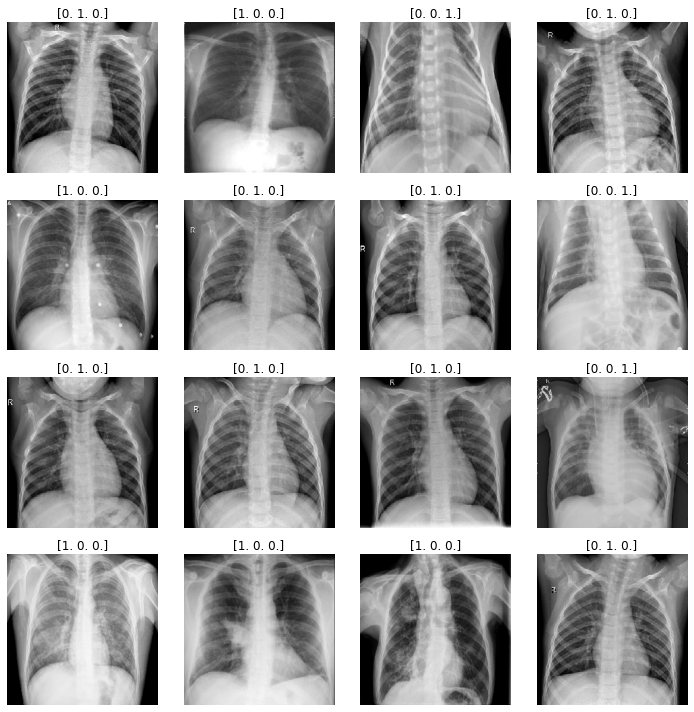

In [6]:
# Visualize samples of training images

class_labels = train_data_gen.class_indices
print(class_labels)

sample_training_images, labels = next(train_data_gen)

def plotImages(images_arr, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.flatten()
    for img, lbs, ax in zip( images_arr, labels, axes):
        ax.imshow(img)
        ax.set_title(lbs)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:16], labels[:16])

In [7]:
# Import the Resnet model
from tensorflow.keras.applications.resnet50 import ResNet50

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D


In [ ]:
# Define your pre-trained model

input_shape = (224,224,3)
pretrained_model = ResNet50(input_shape = input_shape,
                weights = 'imagenet',
                #layers=tf.keras.layers,
                include_top = False)
pretrained_model.trainable = False

2021-08-10 22:25:49.224404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-10 22:25:49.225231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-08-10 22:25:49.225478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-10 22:25:49.226306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-10 22:25:49.226960: I tensorflow/core/common_runtime

 3260416/94765736 [>.............................] - ETA: 57s 

In [8]:
# Make all the layers untrainable 

for layer in pretrained_model.layers:
    layer.trainable = False

In [19]:
# Define your model

model = Sequential()

model.add(pretrained_model)

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary() 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 301059    
_________________________________________________________________
activation_3 (Activation)    (None, 3)                 0         
Total params: 23,888,771
Trainable params: 301,059
Non-trainable params: 23,587,712
_________________________________________________________________


In [20]:
# Define early stopping and model checkpoint for optimizing epoch number and saving the best model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
patience=20)

mc = ModelCheckpoint('covid_19_resnet1.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

In [21]:
# Compile and fit your model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
with tf.device('/gpu:0'):
    history = model.fit_generator(train_data_gen,
                              steps_per_epoch=train_data_gen.samples/train_data_gen.batch_size,
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=val_data_gen.samples/val_data_gen.batch_size,
                              callbacks=[es,mc] )

Epoch 1/20
191/191 [==============================] - 169s 858ms/step - loss: 2.3292 - accuracy: 0.5831 - val_loss: 0.3135 - val_accuracy: 0.9013

Epoch 00001: accuracy improved from -inf to 0.66846, saving model to covid_19_resnet1.h5
Epoch 2/20
191/191 [==============================] - 180s 936ms/step - loss: 0.5668 - accuracy: 0.7831 - val_loss: 0.4007 - val_accuracy: 0.8825

Epoch 00002: accuracy improved from 0.66846 to 0.79270, saving model to covid_19_resnet1.h5
Epoch 3/20
191/191 [==============================] - 177s 924ms/step - loss: 0.6589 - accuracy: 0.7819 - val_loss: 0.2433 - val_accuracy: 0.9192

Epoch 00003: accuracy improved from 0.79270 to 0.80068, saving model to covid_19_resnet1.h5
Epoch 4/20
191/191 [==============================] - 179s 932ms/step - loss: 0.4894 - accuracy: 0.8395 - val_loss: 0.2729 - val_accuracy: 0.9160

Epoch 00004: accuracy improved from 0.80068 to 0.83895, saving model to covid_19_resnet1.h5
Epoch 5/20
191/191 [===========================

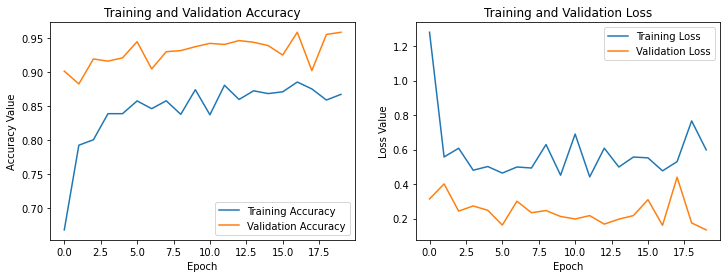

In [22]:
# Plot accuracy and loss for testing and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# Evaluate your model with confusion matrix and classification report

class_labels = train_data_gen.class_indices
print(class_labels)
print('\n')

from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(val_data_gen, val_data_gen.samples // val_data_gen.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix \n')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('\n')
print('Classification Report \n')
target_names = ['COVID-19', 'Normal','Pneumonia-Viral']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

{'COVID-19': 0, 'Normal': 1, 'Pneumonia-Viral': 2}


Confusion Matrix 

[[239   4   8]
 [  1 644   4]
 [ 18  16 292]]


Classification Report 

                 precision    recall  f1-score   support

       COVID-19       0.93      0.95      0.94       251
         Normal       0.97      0.99      0.98       649
Pneumonia-Viral       0.96      0.90      0.93       326

       accuracy                           0.96      1226
      macro avg       0.95      0.95      0.95      1226
   weighted avg       0.96      0.96      0.96      1226

